## Fine-tuning your first Transformer!

In this notebook we'll take a look at fine-tuning a multilingual Transformer model called [XLM-RoBERTa](https://huggingface.co/xlm-roberta-base) for text classification. By the end of this notebook you should know how to:

* Load and process a dataset from the Hugging Face Hub
* Create a baseline with the zero-shot classification pipeline
* Fine-tune and evaluate pretrained model on your data
* Push a model to the Hugging Face Hub

Let's get started!

## Setup

If you're running this notebook on Google Colab or locally, you'll need a few dependencies installed. You can install them with `pip` as follows:

In [2]:
%%capture
! pip install datasets transformers sentencepiece

To be able to share your model with the community there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [4]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-crendential store but this isn't the helper defined on your machine.
You will have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal to set it as the default

git config --global credential.helper store


Then you need to install Git-LFS. Uncomment and execute the following cell:

In [5]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 2s (911 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


## The dataset

In this notebook we'll be using the 🤗 Datasets to load and preprocess our data. If you're new to this library, check out the video below to get some additional context:

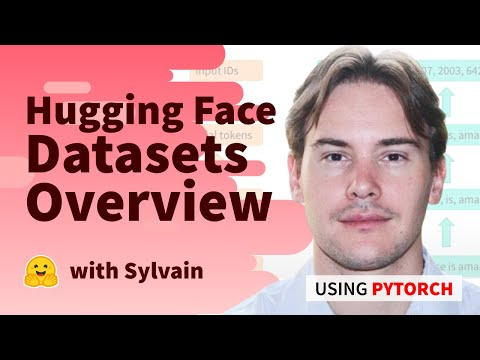

In [6]:
from IPython.display import YouTubeVideo

YouTubeVideo("_BZearw7f0w", width=600, height=400)

In this tutorial we'll use the [Multilingual Amazon Reviews Corpus](https://huggingface.co/datasets/amazon_reviews_multi) (or MARC for short). This is a large-scale collection of Amazon product reviews in several languages: English, Japanese, German, French, Spanish, and Chinese. 

We can download the dataset from the Hugging Face Hub with the 🤗 Datasets library, but first let's take a look at the available subsets (also called configs):

In [7]:
from datasets import get_dataset_config_names

dataset_name = "amazon_reviews_multi"
langs = get_dataset_config_names(dataset_name)
langs

Downloading:   0%|          | 0.00/2.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

['all_languages', 'de', 'en', 'es', 'fr', 'ja', 'zh']

Okay, we can see the language codes associated with each language, as well as an `all_languages` subset which presumably concatenates all the languages together. Let's begin by downloading the English subset with the `load_dataset()` function from 🤗 Datasets:

In [8]:
from datasets import load_dataset

marc_en = load_dataset(path=dataset_name, name="en")
marc_en

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

One cool feature of 🤗 Datasets is that `load_dataset()` will cache the files at `~/.cache/huggingface/dataset/`, so you won't need to re-download the dataset the next time your run the notebook. 

We can see that `marc_en` is a `DatasetDict` object which is similar to a Python dictionary, with each key corresponding to a different split. We can access an element of one of these splits as follows:

In [9]:
# Peek at first element
marc_en["train"][0]

{'language': 'en',
 'product_category': 'furniture',
 'product_id': 'product_en_0740675',
 'review_body': "Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.",
 'review_id': 'en_0964290',
 'review_title': "I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review ...",
 'reviewer_id': 'reviewer_en_0342986',
 'stars': 1}

This certainly looks like an Amazon product review and we can see the number of stars associated with the review, as well as some metadata like the language and product category.

We can also access several rows with a slice:

In [10]:
marc_en["train"][:3]

{'language': ['en', 'en', 'en'],
 'product_category': ['furniture', 'home_improvement', 'home'],
 'product_id': ['product_en_0740675',
  'product_en_0440378',
  'product_en_0399702'],
 'review_body': ["Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.",
  'the cabinet dot were all detached from backing... got me',
  "I received my first order of this product and it was broke so I ordered it again. The second one was broke in more pla

and note that now we get a list of values for each column. This is because 🤗 Datasets is based on Apache Arrow, which defines a typed columnar format that is very memory efficient.

### What if my dataset is not on the Hub?

Note that altough we downloaded the dataset from the Hub, it's also possible to load datasets both locally and from custom URLs. For example, the above dataset lives at the following URL:

In [11]:
dataset_url = "https://amazon-reviews-ml.s3-us-west-2.amazonaws.com/json/train/dataset_en_train.json"

so we can download it manually with `wget`:

In [12]:
!wget {dataset_url}

--2021-10-22 11:57:46--  https://amazon-reviews-ml.s3-us-west-2.amazonaws.com/json/train/dataset_en_train.json
Resolving amazon-reviews-ml.s3-us-west-2.amazonaws.com (amazon-reviews-ml.s3-us-west-2.amazonaws.com)... 52.218.132.9
Connecting to amazon-reviews-ml.s3-us-west-2.amazonaws.com (amazon-reviews-ml.s3-us-west-2.amazonaws.com)|52.218.132.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81989414 (78M) [application/json]
Saving to: ‘dataset_en_train.json’

dataset_en_train.js 100%[===================>]  78.19M  16.0MB/s    in 4.9s    

2021-10-22 11:57:51 (16.0 MB/s) - ‘dataset_en_train.json’ saved [81989414/81989414]



We can then load it locally using the `json` loading script:

In [13]:
load_dataset("json", data_files="dataset_en_train.json")

Using custom data configuration default-4f46d848953c814a


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-4f46d848953c814a/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
})

In [14]:
json -n 3 dataset_en_train.json

SyntaxError: ignored

You can actually skip the manual download step entirely by pointing `data_files` directly to the URL:

In [15]:
load_dataset("json", data_files=dataset_url)

Using custom data configuration default-7035781b4085a7f6


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-7035781b4085a7f6/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
})

Now that we've had a quick look at the objects in 🤗 Datasets, let's explore the data in more detail by using our favourite tool - Pandas!

## From Datasets to DataFrames and back

🤗 Datasets is designed to be interoperable with libraries like Pandas, as well as NumPy, PyTorch, TensorFlow, and JAX. To enable the conversion between various third-party libraries, 🤗 Datasets provides a Dataset.set_format() function. This function only changes the output format of the dataset, so you can easily switch to another format without affecting the underlying data format which is Apache Arrow. The formatting is done in-place, so let’s convert our dataset to Pandas and look at a random sample:

In [16]:
from IPython.display import display, HTML

marc_en.set_format("pandas")
df = marc_en["train"][:]
# Create a random sample
sample = df.sample(n=5, random_state=42)
display(HTML(sample.to_html()))

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
119737,en_0522546,product_en_0681589,reviewer_en_0687817,3,"Not strong enough to run a small 120v vacuum cleaner, to clean car.",Not strong enough to run a small 120v vacuum cleaner ...,en,lawn_and_garden
72272,en_0612910,product_en_0295449,reviewer_en_0312138,2,"The leg openings are a little small, but other than that the suit fits nicely, and is high quality material. Edit: I have been wearing this for less than two months and it is 100% worn out. It has worn so thin in multiple spots that it’s no longer appropriate for wearing in public, I have to throw it away. This is unacceptable.",Crap,en,apparel
158154,en_0983065,product_en_0295095,reviewer_en_0927618,4,Really cute mug. I would have given 5 stars if it were a bit bigger.,Four Stars,en,kitchen
65426,en_0206761,product_en_0563487,reviewer_en_0936741,2,Well it’s looks and feels okay but it most certainly does not have 4 pockets that’s a lie it has 3 so that’s pretty messed up to say it has 4 when it’s only 3 the fabric is super stiff hopefully after washing it will be better,Lies!!,en,industrial_supplies
30074,en_0510474,product_en_0704805,reviewer_en_0417600,1,"Very, very thin, you can bend them with you fingers with no problem! Print is small.. More of a decoration. Would give 1/2 star!",Thin and bendable :(,en,pet_products


We can see that the column headers are the same as we saw in the Arrow format and from the reviews we can see that negative reviews are associated with a lower star rating. Since we're now dealing with a `pandas.DataFrame` we can easily query our dataset. For example, let's see what the distribution of reviews per product category looks like: 

In [17]:
df["product_category"].value_counts()

home                        17679
apparel                     15951
wireless                    15717
other                       13418
beauty                      12091
drugstore                   11730
kitchen                     10382
toy                          8745
sports                       8277
automotive                   7506
lawn_and_garden              7327
home_improvement             7136
pet_products                 7082
digital_ebook_purchase       6749
pc                           6401
electronics                  6186
office_product               5521
shoes                        5197
grocery                      4730
book                         3756
baby_product                 3150
furniture                    2984
jewelry                      2747
camera                       2139
industrial_supplies          1994
digital_video_download       1364
luggage                      1328
musical_instruments          1102
video_games                   775
watch         

Okay, the `home`, `wireless`, and `sports` categories seem to be the most popular. How about the distribution of star ratings?

In [18]:
df["stars"].value_counts()

5    40000
4    40000
3    40000
2    40000
1    40000
Name: stars, dtype: int64

In this case we can see that the dataset is balanced across each star rating, which will make it somewhat easier to evaluate our models on. Imbalanced datasets are much more common in the real-world and in these cases some additional tricks like up- or down-sampling are usually needed.

Now that we've got a rough idea about the kind of data we're dealing with, let's reset the output format from `pandas` back to `arrow`:

In [19]:
marc_en.reset_format()

## Filtering for a product category

Although we could go ahead and fine-tune a Transformer model on the whole set of 200,000 English reviews, this will take several hours on a single GPU. So instead, we'll focus on fine-tuning a model for a single product category! In 🤗 Datasets, we can filter data very quickly by using the `Dataset.filter()` method. This method expects a function that returns Boolean values, in our case `True` if the `product_category` matches the chosen category and `False` otherwise. Here's one way to implement this, and we'll pick the `sports` category as the domain to train on:

In [20]:
product_category = "book"

def filter_for_product(example, product_category=product_category):
    return example["product_category"] == product_category

Now when we pass `filter_for_product()` to `Dataset.filter()` we get a filtered dataset:

In [21]:
product_dataset = marc_en.filter(filter_for_product)
product_dataset

  0%|          | 0/200 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 3756
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 82
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 105
    })
})

Yep, this looks good - we have 13,748 reviews in the train split which agrees the number we saw in the distribution of categories earlier. Let's do a quick sanity check by taking a look at a few samples. Here 🤗 Datasets provides `Dataset.shuffle()` and `Dataset.select()` functions that we can chain to get a random sample:

In [23]:
product_dataset["train"].shuffle(seed=42).select(range(3))[:]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609/cache-419040e53d699d09.arrow


{'language': ['en', 'en', 'en'],
 'product_category': ['book', 'book', 'book'],
 'product_id': ['product_en_0534721',
  'product_en_0492677',
  'product_en_0242047'],
 'review_body': ['18 month old has limited interest in this. He LOVES the Farm Animals Touch and Sound by the same company (it’s his favorite!) - but this was not a winner. I think because some of the sounds are beyond his ability to repeat or recreate. Or he has no familiarity (he likes the semi one but his uncle is a trucker and he knows semis).',
  'Stories are only ok. Some aren’t really stories, just explanations of things. We liked the 5 minute Frozen and 5 minute Star Wars books better.',
  "It's okay, not much to it. Helpful if you're just getting into the field. I thought it would have more to it, nothing you wouldn't already know having done the job for a few months."],
 'review_id': ['en_0217826', 'en_0395899', 'en_0745242'],
 'review_title': ['Great',
  'Stories were disappointing',
  'Very basic, quick read']

Okay, now that we have our corpus of book reviews, let's do one last bit of data preparation: creating label mappings from star ratings to human readable strings.

## Mapping the labels

During training, 🤗 Transformers expects the labels to be ordered, starting from 0 to N. But we've seen that our star ratings range from 1-5, so let's fix that. While we're at it, we'll create a mapping between the label IDs and names, which will be handy later on when we want to run inference with our model. First we'll define the label mapping from ID to name:

In [24]:
label_names = ["terrible", "poor", "ok", "good", "great"]
id2label = {idx:label for idx, label in enumerate(label_names)}
id2label

{0: 'terrible', 1: 'poor', 2: 'ok', 3: 'good', 4: 'great'}

We can then apply this mapping to our whole dataset by using the `Dataset.map()` method. Similar to the `Dataset.filter()` method, this one expects a function which receives examples as input, but returns a Python dictionary as output. The keys of the dictionary correspond to the columns, while the values correspond to the column entries. The following function creates two new columns:

* A `labels` column which is the star rating shifted down by one
* A `label_name` column which provides a nice string for each rating

In [25]:
def map_labels(example):
    # Shift labels to start from 0
    label_id = example["stars"] - 1
    return {"labels": label_id, "label_name": id2label[label_id]}

To apply this mapping, we simply feed it to `Dataset.map` as follows:

In [26]:
product_dataset = product_dataset.map(map_labels)
# Peek at the first example
product_dataset["train"][0]

  0%|          | 0/3756 [00:00<?, ?ex/s]

  0%|          | 0/82 [00:00<?, ?ex/s]

  0%|          | 0/105 [00:00<?, ?ex/s]

{'label_name': 'terrible',
 'labels': 0,
 'language': 'en',
 'product_category': 'book',
 'product_id': 'product_en_0447174',
 'review_body': 'I ordered this book on February 11. It never arrived.',
 'review_id': 'en_0369494',
 'review_title': 'Failure to send book',
 'reviewer_id': 'reviewer_en_0879303',
 'stars': 1}

Great, it works! We'll also need the reverse label mapping later, so let's define it here: 

In [27]:
label2id = {v:k for k,v in id2label.items()}

## From text to tokens

Like other machine learning models, Transformers expect their inputs in the form of numbers (not strings) and so some form of preprocessing is required. For NLP, this preprocessing step is called _tokenization_. Tokenization converts strings into atomic chunks called tokens, and these tokens are subsequently encoded as numerical vectors. 

For more information about tokenizers, check out the following video:

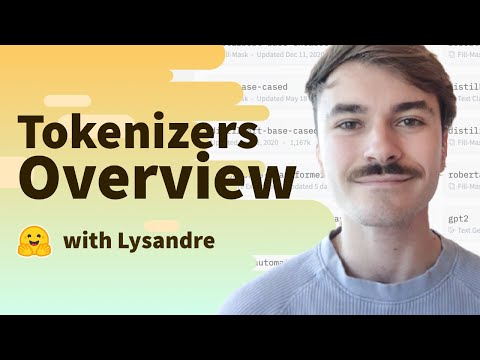

In [28]:
YouTubeVideo("VFp38yj8h3A", width=600, height=400)

Each pretrained model comes with its own tokenizer, so to get started let's download the tokenizer of XLM-RoBERTa from the Hub:

In [29]:
from transformers import AutoTokenizer

model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

The tokenizer has a few interesting attributes such as the vocabulary size:

In [30]:
tokenizer.vocab_size

250002

This tells us that XLM-R has 250,002 tokens that is can use to represent text with. Some of the tokens are called _special tokens_ to indicate whether a token is the start or end of a sentence, or corresponds to the mask that is associated with language modeling. Here's what the special tokens look like for XLM-R:

In [31]:
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'cls_token': '<s>',
 'eos_token': '</s>',
 'mask_token': '<mask>',
 'pad_token': '<pad>',
 'sep_token': '</s>',
 'unk_token': '<unk>'}

When you feed strings to the tokenizer, you'll get at least two fields (some models have more, depending on how they're trained):

* `input_ids`: These correspond to the numerical encodings that map each token to an integer
* `attention_mask`: This indicates to the model which tokens should be ignored when computing self-attention

Let's see how this works with a simple example. First we encode the string:

In [32]:
encoded_str = tokenizer("Today I'm giving an NLP workshop at MLT")
encoded_str

{'input_ids': [0, 38396, 87, 25, 39, 68772, 142, 541, 37352, 42819, 99, 276, 27026, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

and then decode the input IDs to see the mapping explicitly:

In [33]:
for token in encoded_str["input_ids"]:
    print(token, tokenizer.decode([token]))

0 <s>
38396 Today
87 I
25 '
39 m
68772 giving
142 an
541 N
37352 LP
42819 workshop
99 at
276 M
27026 LT
2 </s>


So to prepare our inputs, we simply need to apply the tokenizer to each example in our corpus. As before, we'll do this with `Dataset.map()` so let's write a simple function to do so:

In [34]:
def tokenize_reviews(examples):
    return tokenizer(examples["review_body"], truncation=True, max_length=180)

Here we've enabled truncation, so the tokenizer will cut any inputs that are longer than 180 tokens (which is the setting used in the MARC paper). With this function we can go ahead and tokenize the whole corpus:

In [35]:
tokenized_dataset = product_dataset.map(tokenize_reviews, batched=True)
tokenized_dataset

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label_name', 'labels', 'language', 'product_category', 'product_id', 'review_body', 'review_id', 'review_title', 'reviewer_id', 'stars'],
        num_rows: 3756
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label_name', 'labels', 'language', 'product_category', 'product_id', 'review_body', 'review_id', 'review_title', 'reviewer_id', 'stars'],
        num_rows: 82
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label_name', 'labels', 'language', 'product_category', 'product_id', 'review_body', 'review_id', 'review_title', 'reviewer_id', 'stars'],
        num_rows: 105
    })
})

In [36]:
tokenized_dataset["train"][0]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [0,
  87,
  12989,
  297,
  903,
  12877,
  98,
  22482,
  4541,
  1650,
  8306,
  174920,
  5,
  2],
 'label_name': 'terrible',
 'labels': 0,
 'language': 'en',
 'product_category': 'book',
 'product_id': 'product_en_0447174',
 'review_body': 'I ordered this book on February 11. It never arrived.',
 'review_id': 'en_0369494',
 'review_title': 'Failure to send book',
 'reviewer_id': 'reviewer_en_0879303',
 'stars': 1}

This looks good, so now let's load a pretrained model!

## Loading a pretrained model

To load a pretrained model from the Hub is quite simple: just select the appropriate `AutoModelForXxx` class and use the `from_pretrained()` function with the model checkpoint. In our case, we're dealing with 5 classes (one for each star) so to initialise the model we'll provide this information along with the label mappings:

In [37]:
from transformers import AutoModelForSequenceClassification

num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

These warnings are perfectly normal - they are telling us that the weights in the head of the network are randomly initialised and so we should fine-tune the model on a downstream task.

Now that we have a model, the next step is to initialise a `Trainer` that will take care of the training loop for us. Let's do that next.

**Additional notes:**
The pretrained model can be switched between different machine learning frameworks such as PyTorch, TensorFlow, or JAX.

## Creating a Trainer

To create a `Trainer`, we usually need a few basic ingredients:

* A `TrainingArguments` class to define all the hyperparameters
* A `compute_metrics` function to compute metrics during evaluation
* Datasets to train and evaluate on

For more information about the `Trainer` check out the following video:

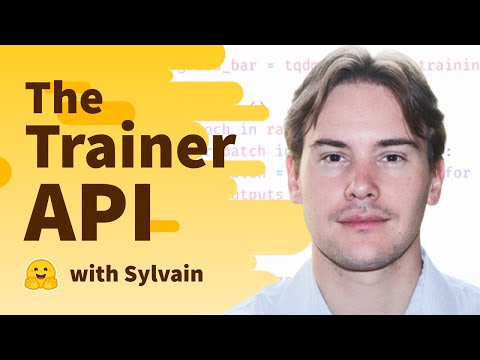

In [38]:
YouTubeVideo("nvBXf7s7vTI", width=600, height=400)

Let's start with the `TrainingArguments`:

In [39]:
from transformers import TrainingArguments

model_name = model_checkpoint.split("/")[-1]
batch_size = 16
num_train_epochs = 2
logging_steps = len(tokenized_dataset["train"]) // (batch_size * num_train_epochs)

args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-marc-en",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    logging_steps=logging_steps,
    push_to_hub=True,
)

Here we've defined `output_dir` to save our checkpoints and tweaked some of the default hyperparameters like the learning rate and weight decay. The `push_to_hub` argument will push each checkpoint to the Hub automatically for us, so we can reuse the model at any point in the future!

Now that we've defined the hyperparameters, the next step is to define the metrics. In the MARC paper, the authors point out that one should use the mean absolute error (MAE) for star ratings because:

> star ratings for each review are ordinal, and a 2-star prediction for a 5-star review should be penalized more heavily than a 4-star prediction for a 5-star review.

We'll take the same approach here and we can get the metric easily from Scikit-learn as follows:

In [40]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"MAE": mean_absolute_error(labels, predictions)}

With these ingredients we can now instantiate a `Trainer`:

In [41]:
from transformers import Trainer 

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Cloning https://huggingface.co/yeokeat/xlm-roberta-base-finetuned-marc-en into local empty directory.


Note that here we've also provided the tokenizer to the `Trainer`: doing so will ensure that all of our examples are automatically padded to the longest example in each batch. This is needed so that matrix operations in the forward pass of the model can be computed. 

With our `Trainer`, it is then a simple matter to train the model:

In [42]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: review_body, label_name, review_id, stars, reviewer_id, product_category, language, review_title, product_id.
***** Running training *****
  Num examples = 3756
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 470


Epoch,Training Loss,Validation Loss,Mae
1,1.119900,0.939574,0.524390
2,0.958700,0.916024,0.426829


The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: review_body, label_name, review_id, stars, reviewer_id, product_category, language, review_title, product_id.
***** Running Evaluation *****
  Num examples = 82
  Batch size = 16
Saving model checkpoint to xlm-roberta-base-finetuned-marc-en/checkpoint-235
Configuration saved in xlm-roberta-base-finetuned-marc-en/checkpoint-235/config.json
Model weights saved in xlm-roberta-base-finetuned-marc-en/checkpoint-235/pytorch_model.bin
tokenizer config file saved in xlm-roberta-base-finetuned-marc-en/checkpoint-235/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-marc-en/checkpoint-235/special_tokens_map.json
tokenizer config file saved in xlm-roberta-base-finetuned-marc-en/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-marc-en/special_tokens_map.json
The following columns in the eval

TrainOutput(global_step=470, training_loss=1.1238403497858251, metrics={'train_runtime': 195.4307, 'train_samples_per_second': 38.438, 'train_steps_per_second': 2.405, 'total_flos': 503752017410256.0, 'train_loss': 1.1238403497858251, 'epoch': 2.0})

Nice, with just a few mintues of training, we've managed to halve our error compared to the zero-shot baseline! After training is complete, we can push the commits to our repository on the Hub:

In [ ]:
trainer.push_to_hub(commit_message="Training complete!")

Saving model checkpoint to xlm-roberta-base-finetuned-marc-en
Configuration saved in xlm-roberta-base-finetuned-marc-en/config.json
Model weights saved in xlm-roberta-base-finetuned-marc-en/pytorch_model.bin
tokenizer config file saved in xlm-roberta-base-finetuned-marc-en/tokenizer_config.json
Special tokens file saved in xlm-roberta-base-finetuned-marc-en/special_tokens_map.json


Upload file pytorch_model.bin:   0%|          | 32.0k/1.04G [00:00<?, ?B/s]

Upload file runs/Oct21_20-46-05_vorace/events.out.tfevents.1634842116.vorace: 100%|##########| 4.94k/4.94k [00…

To https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en
   46101cc..ed25dda  main -> main

Dropping the following result as it does not have all the necessary field:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'dataset': {'name': 'amazon_reviews_multi', 'type': 'amazon_reviews_multi', 'args': 'en'}}
To https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en
   ed25dda..4edf98b  main -> main



'https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/commit/ed25ddabff2ca185be2c7bd610b003858058c749'

## Evaluating cross-lingual transfer

Now that we're fine-tuned our model on a English subset, we can evaluate its ability to transfer to other languages. To do so, we'll load the validation set in a given language, apply the same filtering and preprocessing that we did for the English subset, and finally use `Trainer.evaluate()` to compute the metrics. The following function does the trick: 

In [43]:
def evaluate_corpus(lang):
    # Load the language subset
    dataset = load_dataset(dataset_name, lang, split="validation")
    # Filter for the `sports` product category
    product_dataset = dataset.filter(filter_for_product)
    # Map and create label columns
    product_dataset = product_dataset.map(map_labels)
    # Tokenize the inputs
    tokenized_dataset = product_dataset.map(tokenize_reviews, batched=True)
    # Generate predictions and metrics
    preds = trainer.evaluate(eval_dataset=tokenized_dataset)
    return {"MAE": preds["eval_MAE"]}

Let's start with English (for reference our MAE on English was around 0.5):

In [44]:
evaluate_corpus("fr")

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/81.9M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.02M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/fr/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/215 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: review_body, label_name, review_id, stars, reviewer_id, product_category, language, review_title, product_id.
***** Running Evaluation *****
  Num examples = 215
  Batch size = 16


{'MAE': 0.5767441860465117}

Not bad! Our fine-tuned English model is able to transfer to English at roughly the same performance. How about French?

In [45]:
evaluate_corpus("ja")

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/169M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/4.19M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/ja/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/121 [00:00<?, ?ex/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the evaluation set  don't have a corresponding argument in `XLMRobertaForSequenceClassification.forward` and have been ignored: review_body, label_name, review_id, stars, reviewer_id, product_category, language, review_title, product_id.
***** Running Evaluation *****
  Num examples = 121
  Batch size = 16


{'MAE': 0.6611570247933884}

Nice, this is very similar too! This shows the great power of multilingual models - provided your target language was included in the pretraining, there's a good chance you'll only need to tune and deploy a single model in production instead of running one per language. 

This wraps up our training and evaluation step - one last thing to try is seeing how we can interact with our model in a `pipeline`.

## Using your fine-tuned model

In [46]:
from transformers import pipeline 

finetuned_checkpoint = "lewtun/xlm-roberta-base-finetuned-marc-en"
classifier = pipeline("text-classification", model=finetuned_checkpoint)

https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpmuirltv3


Downloading:   0%|          | 0.00/976 [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/037d460e3f122274751f63b09da897e8132529bdefe7de21b0fb1ad299d308b8.2b84791fe464e01eeffac0776c6630b7f5c8a4aa14a39ee1292d706acb9346f2
creating metadata file for /root/.cache/huggingface/transformers/037d460e3f122274751f63b09da897e8132529bdefe7de21b0fb1ad299d308b8.2b84791fe464e01eeffac0776c6630b7f5c8a4aa14a39ee1292d706acb9346f2
loading configuration file https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/037d460e3f122274751f63b09da897e8132529bdefe7de21b0fb1ad299d308b8.2b84791fe464e01eeffac0776c6630b7f5c8a4aa14a39ee1292d706acb9346f2
Model config XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/c97412612696ce55e0c33d534b536ef0c913cbac8cac07f99c987b28ec005e23.793434c46167441b5d28ce8d9d3cb67723caadee7fb7b0d41cfd5e4147cb2748
creating metadata file for /root/.cache/huggingface/transformers/c97412612696ce55e0c33d534b536ef0c913cbac8cac07f99c987b28ec005e23.793434c46167441b5d28ce8d9d3cb67723caadee7fb7b0d41cfd5e4147cb2748
loading weights file https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/c97412612696ce55e0c33d534b536ef0c913cbac8cac07f99c987b28ec005e23.793434c46167441b5d28ce8d9d3cb67723caadee7fb7b0d41cfd5e4147cb2748
All model checkpoint weights were used when initializing XLMRobertaForSequenceClassification.

All the weights of XLMRobertaForSequenceClassification were initialized from the model checkpoint at lewtun/xlm-roberta-base-fi

Downloading:   0%|          | 0.00/398 [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/3384f362cedf6ef145b43b1b52d70d29c95a4f67e83a66d66ec230f7a21e9b10.b36482fbec4a714d3cfec99e0b05f4fdeec9e759090a78aed5597583a8b4783d
creating metadata file for /root/.cache/huggingface/transformers/3384f362cedf6ef145b43b1b52d70d29c95a4f67e83a66d66ec230f7a21e9b10.b36482fbec4a714d3cfec99e0b05f4fdeec9e759090a78aed5597583a8b4783d
https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/sentencepiece.bpe.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpw0qxrgmh


Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/sentencepiece.bpe.model in cache at /root/.cache/huggingface/transformers/8829ed2a3689d2958f997a76316030f4eabc8862fc37e950c0edf01093c6b2b2.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
creating metadata file for /root/.cache/huggingface/transformers/8829ed2a3689d2958f997a76316030f4eabc8862fc37e950c0edf01093c6b2b2.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpl61iy5gk


Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/9a5e2f33f5c3c3f16829f9c1db471f77b971568661178e86b44ce063ee371908.f00bf26b5c5328dc3c4844eb99c23392a32b9c4358d1144a6d617efbc1403e11
creating metadata file for /root/.cache/huggingface/transformers/9a5e2f33f5c3c3f16829f9c1db471f77b971568661178e86b44ce063ee371908.f00bf26b5c5328dc3c4844eb99c23392a32b9c4358d1144a6d617efbc1403e11
https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpxf6gqia5


Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

storing https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/28b7ae4c7f7a27813bc8966d3f9348c06d36b33eced58906798205ac0ed4bced.a11ebb04664c067c8fe5ef8f8068b0f721263414a26058692f7b2e4ba2a1b342
creating metadata file for /root/.cache/huggingface/transformers/28b7ae4c7f7a27813bc8966d3f9348c06d36b33eced58906798205ac0ed4bced.a11ebb04664c067c8fe5ef8f8068b0f721263414a26058692f7b2e4ba2a1b342
loading file https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/8829ed2a3689d2958f997a76316030f4eabc8862fc37e950c0edf01093c6b2b2.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
loading file https://huggingface.co/lewtun/xlm-roberta-base-finetuned-marc-en/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/9a5e2f33f5c3c3f16829f9c1db471f77b971568661178e86b44ce063ee37

In [47]:
classifier("I loved reading the Hunger Games!")

[{'label': 'great', 'score': 0.8203269243240356}]

In [48]:
classifier("ハンガーゲーム」を読むのが好きだった!")

[{'label': 'good', 'score': 0.5864880084991455}]